# A toy Example
In this example we'll try to learn a generator sampling from a simple multivariate Gaussian.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.parallel
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import numpy as np
import matplotlib.pyplot as plt

# vegans imports:
from vegans import MMGAN, WGAN, WGANGP
from vegans.utils import plot_losses, plot_image_samples

ngpus = 0

In [ ]:
""" tests
"""
N = 100
cov_mat = 0.3 * np.ones((N,N))

# define 10 ranges:
for i in range(5):
    cov_mat[i*20:(i+1)*20,i*20:(i+1)*20] = 0.7

plt.imshow(cov_mat)
plt.title('Data generating process covariance matrix')

# sample. TODO: also retrieve non-trivial mean?
samples = np.random.multivariate_normal(mean=np.array([0. for _ in range(N)]), cov=cov_mat, size=1000)

# re-cover matrix
cov_mat_recovered = np.cov(samples.T)

plt.figure()
plt.imshow(cov_mat_recovered)
plt.title('Sample cov matrix from multivariate Gaussian')

In [52]:
nz = 5
N = 100

In [41]:
class GaussianDataset(Dataset):
    def __init__(self, mu=0., stdev=1, N=2, len_=10000):
        self.mu = np.array([mu for _ in range(N)])
        self.stdev = stdev
        self.N = N
        self.len_ = len_

    def __getitem__(self, idx):
        # return np.random.normal(loc=self.mu, scale=self.stdev, size=(self.N,)).astype(np.float32), 0
        return np.random.multivariate_normal(mean=self.mu, cov=cov_mat).astype(np.float32), 0

    def __len__(self):
        return self.len_

In [42]:
dataset = GaussianDataset(N=N)
dataloader = DataLoader(dataset, batch_size=16)

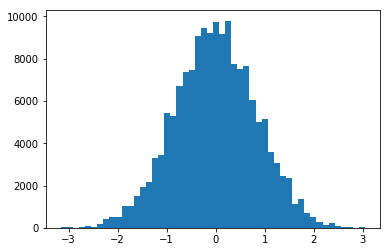

In [43]:
""" Look at our (flattened) data distribution
"""
vals = []
for _ in range(100):
    vals += list(next(iter(dataloader))[0].flatten())
plt.hist(vals, bins=50);

In [44]:
""" Define a critic
"""
class Critic(nn.Module):
    def __init__(self):
        super(Critic, self).__init__()
        self.fc1 = nn.Linear(N, 50)
        self.bn1 = nn.BatchNorm1d(num_features=50)
        self.fc2 = nn.Linear(50, 1)

    def forward(self, x):
        x = self.bn1(F.relu(self.fc1(x)))
        x = self.fc2(x)
        x = torch.sigmoid(x)
        return x
    
""" Define a generator
"""
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.fc1 = nn.Linear(nz, 30)
        self.bn1 = nn.BatchNorm1d(num_features=30)
        self.fc2 = nn.Linear(30, N)

    def forward(self, x):
        x = self.bn1(F.relu(self.fc1(x)))
        x = self.fc2(x)
        # x = torch.tanh(self.fc2(x))
        return x

In [60]:
""" Create those networks
"""
critic = Critic()
generator = Generator()

In [62]:
def plot_generator_cov(generator_):
    """ Try the generator on a noise mini-batch and compute sample covariance matrix
    """
    z = torch.from_numpy(np.random.randn(10000, nz).astype(np.float32))
    samples = generator_(z)
    cov_mat_est = np.cov(samples.detach().numpy().T)

    plt.imshow(cov_mat_est)

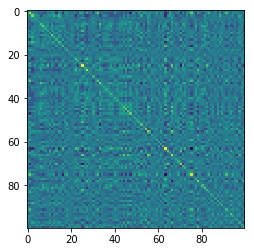

In [63]:
""" What's the covariance before training?
"""
plot_generator_cov(generator)

In [64]:
gan = WGAN(generator, critic, dataloader, ngpu=ngpus, nr_epochs=20, nz=nz, print_every=500)

device: cpu


In [ ]:
gan.train();

[0/20][500/625](- iter/s)	Loss_D: 0.000	Loss_G: -0.498
[1/20][375/625](57.994 iter/s)	Loss_D: -0.000	Loss_G: -0.498
[2/20][250/625](54.432 iter/s)	Loss_D: 0.000	Loss_G: -0.497
[3/20][125/625](52.951 iter/s)	Loss_D: 0.000	Loss_G: -0.496
[4/20][0/625](52.228 iter/s)	Loss_D: 0.000	Loss_G: -0.496
[4/20][500/625](54.619 iter/s)	Loss_D: -0.000	Loss_G: -0.496
[5/20][375/625](54.967 iter/s)	Loss_D: 0.000	Loss_G: -0.496
[6/20][250/625](54.322 iter/s)	Loss_D: 0.000	Loss_G: -0.496
[7/20][125/625](53.761 iter/s)	Loss_D: -0.000	Loss_G: -0.496
[8/20][0/625](56.318 iter/s)	Loss_D: -0.000	Loss_G: -0.496
[8/20][500/625](55.365 iter/s)	Loss_D: -0.000	Loss_G: -0.496
[9/20][375/625](55.182 iter/s)	Loss_D: -0.000	Loss_G: -0.496
[10/20][250/625](52.276 iter/s)	Loss_D: -0.000	Loss_G: -0.496
[11/20][125/625](50.773 iter/s)	Loss_D: -0.000	Loss_G: -0.496
[12/20][0/625](53.492 iter/s)	Loss_D: 0.000	Loss_G: -0.496


In [16]:
samples_l, D_losses, G_losses = gan.get_training_results()

(array([  3.,   1.,   3.,   3.,   5.,  10.,   9.,  14.,  20.,  29.,  40.,
         55.,  70.,  96., 116., 162., 213., 295., 331., 409., 446., 505.,
        511., 462., 479., 409., 378., 323., 274., 194., 139., 114.,  77.,
         48.,  35.,  29.,  32.,  16.,  15.,   9.,   7.,   5.,   5.,   0.,
          0.,   1.,   0.,   0.,   1.,   2.]),
 array([-1.6992811 , -1.6255714 , -1.5518616 , -1.4781519 , -1.4044422 ,
        -1.3307323 , -1.2570226 , -1.1833129 , -1.1096032 , -1.0358934 ,
        -0.9621837 , -0.888474  , -0.81476426, -0.7410545 , -0.66734475,
        -0.593635  , -0.5199253 , -0.44621554, -0.3725058 , -0.29879606,
        -0.22508633, -0.15137659, -0.07766686, -0.00395712,  0.06975262,
         0.14346236,  0.2171721 ,  0.29088184,  0.36459157,  0.43830132,
         0.51201105,  0.5857208 ,  0.6594305 ,  0.7331403 ,  0.80685   ,
         0.88055974,  0.95426947,  1.0279793 ,  1.101689  ,  1.1753987 ,
         1.2491084 ,  1.3228182 ,  1.3965279 ,  1.4702376 ,  1.5439473 ,
 

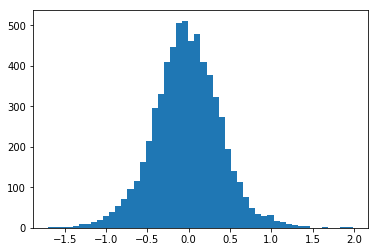

In [17]:
plt.hist(list(samples_l.items())[-1][1].detach().numpy().flatten(), bins=50)

In [ ]:
plot_losses(G_losses, D_losses)

In [ ]:
# TODO: show how covariance matrix evolves over training